# Deep Learning From Scratch

## ODSC East 2019

# Motivation

## Many resources to learn about neural networks.

Code / example-based

* PyTorch/TensorFlow documentation

## Example from PyTorch documentation

```python
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random input and output data
x = torch.randn(N, D_in, device=device, dtype=dtype)
y = torch.randn(N, D_out, device=device, dtype=dtype)

# Randomly initialize weights
w1 = torch.randn(D_in, H, device=device, dtype=dtype)
w2 = torch.randn(H, D_out, device=device, dtype=dtype)

learning_rate = 1e-6
for t in range(500):
    # Forward pass: compute predicted y
    h = x.mm(w1)
    h_relu = h.clamp(min=0)
    y_pred = h_relu.mm(w2)

    # Compute and print loss
    loss = (y_pred - y).pow(2).sum().item()
    print(t, loss)

    # Backprop to compute gradients of w1 and w2 with respect to loss
    grad_y_pred = 2.0 * (y_pred - y)
    grad_w2 = h_relu.t().mm(grad_y_pred)
    grad_h_relu = grad_y_pred.mm(w2.t())
    grad_h = grad_h_relu.clone()
    grad_h[h < 0] = 0
    grad_w1 = x.t().mm(grad_h)

    # Update weights using gradient descent
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2
```

## Totally different code-based approach

* **fast.ai**: "You don't need to understand how things work - just run these few lines of code and train a world-class classifier! Then go back later and understand what is going on."

## Mathematical approach

* Explaining Deep Learning with equations
* Best example: **Ian Goodfellow's [Deep Learning book](https://www.deeplearningbook.org)**

# Contents

* Mathematical/conceptual foundations (don't worry)
    * Functions
    * Derivatives
    * Representing functions as computational graphs
    * Computing derivatives of functions when matrices are involved

* Applying this "first principles"-based approach to build a linear regression
* Extending this to build a neural network
    * Connecting this to how neural networks are usually described

# Contents (continued)

* Moving from first principles Deep Learning building blocks to the elements of Deep Learning models
    * Model
    * Optimizer
    * Loss
    * Trainer
* Using this to build Deep Learning models

* Tricks to make Deep Learning models train better 
    * Softmax cross entropy loss
    * Momentum
    * Weight initialization
    * Learning rate decay
    * Dropout

# Contents (time permitting)

* Convolutional neural networks
* Recurrent neural networks
* PyTorch

# Deep Learning from First Principles

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import ndarray

%matplotlib inline

# Part 1

Note: three ways of thinking about each concept here:

1. Math
2. Code
3. Diagrams

## Functions

### "Math"

$ f(x) = x^2 $

$ \text{ReLU}(x) = \text{max}(x, 0) $

### Code

In [5]:
def square(x: ndarray) -> ndarray:
    '''
    Square each element in the input ndarray.
    '''
    return np.power(x, 2)

def relu(x: ndarray) -> ndarray:
    '''
    Apply the "ReLU" function to each element in the input ndarray.
    '''
    return np.clip(x, 0, None)

### Diagrams

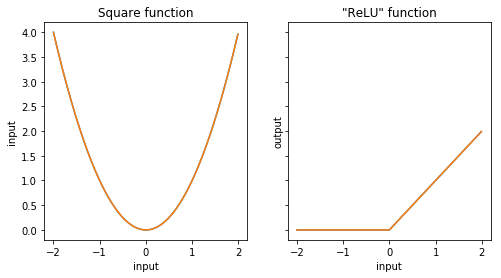

In [7]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(8, 4))  # 2 Rows, 1 Col

input_range = np.arange(-2, 2, 0.01)
ax[0].plot(input_range, square(input_range))
ax[0].plot(input_range, square(input_range))
ax[0].set_title('Square function')
ax[0].set_xlabel('input')
ax[0].set_ylabel('input')

ax[1].plot(input_range, relu(input_range))
ax[1].plot(input_range, relu(input_range))
ax[1].set_title('"ReLU" function')
ax[1].set_xlabel('input')
ax[1].set_ylabel('output');

### Functions as "boxes"

<img src="img/02_two_continuous_functions.png" width=500>

## Derivatives

### Diagram

Intuitively: "slope".

But, there's another way to think about derivatives:

<img src="img/03_string_pulling.png" width=300>

But how to compute this?

### Math

To be precise:

$$
\frac{df}{du}(a) =
\lim_{\Delta \to 0} \frac{{f \left( {a + \Delta } \right) - f\left( a - \Delta \right)}}{2 * \Delta }
$$

Can be estimated by:

$$
\frac{df}{du}(a) =
\frac{f(a + 0.001) - f(a - 0.001)}{0.002}
$$

Let's code this up!

### Code

In [10]:
from typing import Callable

def deriv(func: Callable[[ndarray], ndarray],
          input_: ndarray,
          delta: float = 0.001) -> ndarray:
    '''
    Evaluates the derivative of a function "func" at every element in the "input_" array.
    '''
    return (func(input_ + delta) - func(input_ - delta)) / (2 * delta)

## Nested functions

### Diagram

<img src="img/04_x_f1_f2_y.png" width=400>

<img src="img/05_x_f1f2_y.png" width=400>

Two different ways of representing the same thing!